# Neural Networks

In [6]:
import time
import os
import pprint
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tqdm.notebook as tq
import utils
from pydub import AudioSegment
from tkinter import Tcl # file sorting by name

# Creation of labels

### Dictionary creation for the classes

We want a dictionary indicating a numbeer for each genre:

{0: 'Hip-Hop', 1: 'Pop', 2: 'Folk', 3: 'Rock', 4: 'Experimental', 5: 'International', 6: 'Electronic', 7: 'Instrumental'}

### Creation of the labels vector

In [7]:
def create_single_dataset(folder_path, tracks_dataframe, genre_dictionary):    
    labels = []
   
    _, file_list = get_sorted_file_paths(folder_path)
    
    for i,file in enumerate(file_list):
        #print("considering file:",file, "({}/{})".format(i,len(file_list)))
        track_id_clip_id = file.split('.')[0]
        track_id = track_id_clip_id.split('_')[0]
        #print("track id with clip: {}, track id: {}".format(track_id_clip_id, track_id))
        genre = tracks_dataframe.loc[int(track_id)]
        #print("genre from dataframe: ", genre)
        label = genre_dictionary[genre]
        #print("label from dictionary:",label)
        labels.append(label)
    print("labels length: {}".format(len(labels)))
    return labels
    

#create the train,validation and test vectors using the files in the train/validation/test folders
def create_dataset_splitted(folder_path):
    train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
    validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
    test_folder = os.path.join(folder_path,'test') # concatenate train folder to path
    
    print("train_folder:",train_folder)
    print("validation_folder:",validation_folder)
    print("test_folder:",test_folder,"\n")
    
    AUDIO_DIR = os.environ.get('AUDIO_DIR')
    print("audio directory: ",AUDIO_DIR)
    print("Loading tracks.csv...")
    tracks = utils.load('data/fma_metadata/tracks.csv')
    
    #get only the small subset of the dataset
    small = tracks[tracks['set', 'subset'] <= 'small']
    print("small dataset shape:",small.shape)    

    small_training = small.loc[small[('set', 'split')] == 'training']['track']
    small_validation = small.loc[small[('set', 'split')] == 'validation']['track']
    small_test = small.loc[small[('set', 'split')] == 'test']['track']

    print("Track.csv: {} training samples, {} validation samples, {} test samples\n".format(len(small_training), len(small_validation), len(small_test)))

    small_training_top_genres = small_training['genre_top']
    small_validation_top_genres = small_validation['genre_top']
    small_test_top_genres = small_test['genre_top']
    
    #create dictionary of genre classes:
    unique_genres = small_training_top_genres.unique()
    unique_genres = np.array(unique_genres)
    print("there are {} unique genres".format(len(unique_genres)))
    genre_dictionary = {}
    for i,genre in enumerate(unique_genres):
        genre_dictionary[genre] = i
    print("Dictionary of genres created:",genre_dictionary)
    
    
    Y_train = create_single_dataset(train_folder, small_training_top_genres, genre_dictionary)
    Y_validation = create_single_dataset(validation_folder, small_validation_top_genres, genre_dictionary)
    Y_test = create_single_dataset(test_folder, small_test_top_genres, genre_dictionary)
    
    return Y_train, Y_validation, Y_test
 
def get_sorted_file_paths(folder_path):
    file_list = os.listdir(folder_path)
    #sort the dataset files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_list = Tcl().call('lsort', '-dict', file_list) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_list] #join filename with folder path
    #print("There are {} in the folder: {}".format(len(file_list),file_list))
    return file_paths, file_list
    
    
folder_path="data/fma_small_stft_transposed"
Y_train, Y_validation, Y_test = create_dataset_splitted(folder_path)

train_folder: data/fma_small_stft_transposed/train
validation_folder: data/fma_small_stft_transposed/validation
test_folder: data/fma_small_stft_transposed/test 

audio directory:  ./data/fma_small/
Loading tracks.csv...
small dataset shape: (8000, 52)
Track.csv: 6400 training samples, 800 validation samples, 800 test samples

there are 8 unique genres
Dictionary of genres created: {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Rock': 3, 'Experimental': 4, 'International': 5, 'Electronic': 6, 'Instrumental': 7}
labels length: 63970
labels length: 8000
labels length: 8000


# Dataset Class

In [8]:
# Define the custom class for accessing our dataset
class MyDataset(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels=labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # returns a training sample and its label
        file_path = self.file_list[idx]
        label = torch.tensor(self.labels[idx])
        stft_vector = torch.tensor(np.load(file_path)) #load from file
        return stft_vector, label

In [9]:
folder_path="data/fma_small_stft_transposed"

train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
test_folder = os.path.join(folder_path,'test') # concatenate train folder to path

train_file_paths, _ = get_sorted_file_paths(train_folder)
train_dataset = MyDataset(train_file_paths, Y_train)
print("len of train dataset: ",len(train_dataset))

validation_file_paths, _ = get_sorted_file_paths(validation_folder)
validation_dataset = MyDataset(validation_file_paths, Y_validation)
print("len of validation dataset: ",len(validation_file_paths))

test_file_paths, _ = get_sorted_file_paths(test_folder)
test_dataset = MyDataset(test_file_paths, Y_test)
print("len of test dataset: ",len(test_dataset))

len of train dataset:  63970
len of validation dataset:  8000
len of test dataset:  8000


In [10]:
def check_for_dimension_errors(filepaths):
    error_indexes = []
    progress = 0
    for file in filepaths:
        progress+=1
        print("checked {}/{} files".format(progress,len(filepaths)))
        x = np.load(file)
        if(x.shape != (128,513)):
            error_indexes.append(x)
            print("error")
    print("{} errors found in files: {}".format(len(error_indexes),error_indexes))
    for idx,error in enumerate(error_indexes):
        print("index: {}, shape: {}".format(idx,error.shape))

# Network Architecture Definition (nnet1)

In [6]:
class NNet1(nn.Module):
    def __init__(self):
        super(NNet1, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(4, 513), stride=(1,513))
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(4, 1), stride=(1,513))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 1), stride=(1,513))
        self.avgpool = nn.AvgPool2d(kernel_size=(26, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(26, 1))
        self.flatten = nn.Flatten()
        self.dropout=nn.Dropout(0.3)
        self.dense1 = nn.Linear(512, 300)
        self.dense2 = nn.Linear(300, 150)
        self.dense3 = nn.Linear(150, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x=self.dropout(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

# Hyperparameters

In [11]:
BATCH_SIZE=32
EPOCHS=10
LEARNING_RATE=0.0001

learning_rate_list = [0.01, 0.001, 0.0001]
batch_size_list = [128,256,512]

# Train function

In [7]:
def test(model, validation_dataset, Y_validation):
    #Stop parameters learning
    model.eval()
    
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10)
    
    # Definisci i pesi delle classi in base alla loro importanza (puoi sperimentare con questi valori)
    class_weights = torch.tensor([2.5, 2.5, 1.5, 1.0, 0.1, 1.0, 1.5, 2.5])

    # Crea una funzione di perdita con pesi
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    #criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8,8 ), dtype=int)

    correct_maj=0
    
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            
            
            #print("Inputs:",inputs,"size:",inputs.size())
            #print("Labels:",labels,"size:",labels.size())
            inputs=inputs.unsqueeze(1)
            #predict label
            outputs = model(inputs)
            #print("Outputs:",outputs,"size:",outputs.size())
            #compute loss
            #TO DO:adapt it to the voting
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            voting=outputs.sum(dim=0)
            #print("Voting:",voting,"size:",voting.size())
            predicted= torch.argmax(voting)
            #print("winning class",predicted)
            correct += (predicted == labels[0])
            confusion_matrix[predicted][labels[0]]+=1
            
            votes=[0,0,0,0,0,0,0,0]
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                votes[max_index]+=1
            majority_prediction=votes.index(max(votes)) 
            correct_maj += (majority_prediction == labels[0])
            
            
    maj_acc=correct_maj*100/800        
            
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm.plot()
    print(confusion_matrix)
    accuracy = 100*correct / 800 
    average_loss = total_loss / 800
    
    print("Majority:",maj_acc,"\t Probability:",accuracy)
    model.train()
    return accuracy, average_loss


In [8]:
def train(model, dataset, batch_size, num_epochs, learning_rate, verbose = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    counted_labels=[0,0,0,0,0,0,0,0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", content: ",inputs)
                print("\nlabels shape:",labels.size(),", content: ",labels)
            inputs = inputs.unsqueeze(1)
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if(verbose == True):
                print("\noutputs size:",outputs.size(),"content:",outputs)
                print("List of labels until now:",counted_labels)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                counted_labels[labels[index].item()]+=1
                if(labels[index].item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss = test(model, validation_dataset, Y_validation)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

Traing model with batch size=128, lr=0.01


  0%|          | 0/500 [00:00<?, ?batch/s]

[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [100 100 100 100 100 100 100 100]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
Epoch [1/10],Train Loss: 2.1489. Train Accuracy: 12.4859375 Val Loss: 2.149008959531784 Val Accuracy: 12.5


  0%|          | 0/500 [00:00<?, ?batch/s]

KeyboardInterrupt: 

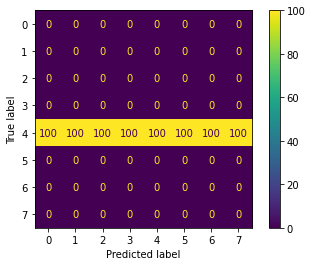

In [10]:
#summary(model, (1, 128, 513))
performance_list = []
model_list = []
directory = 'models/'

for lr in learning_rate_list:   
    for bs in batch_size_list:
        model = NNet1() #reinitialize model
        file_path = directory + 'model' + '_lr_' + str(lr).split('.')[0] + '-' + str(lr).split('.')[1]+ '_bs_' + str(bs)
        print(f"Traing model with batch size={bs}, lr={lr}")
        performance=train(model, train_dataset, batch_size=bs, num_epochs=EPOCHS, learning_rate=lr)
        performance_list.append(performance)
        model_list.append(model)
        print("saving model in", file_path)
        torch.save(model.state_dict(), file_path)
        print(performance_list)

In [9]:
'''
plt.plot(np.arange(1,EPOCHS+1), performance[1][:], label='Loss') 
plt.plot(np.arange(1,EPOCHS+1), performance[0][:], label='Accuracy')
plt.legend()  # Display the legend showing the labels
plt.show()
print(performance[0][:])
'''

parameter_list = []
for lr in learning_rate_list:
    for bs in batch_size_list:
        parameter_list.append([lr,bs])

for performance, parameters in zip(performance_list, parameter_list):
    plt.plot(np.arange(1,EPOCHS+1), performance[1][:], label='Val Loss') 
    plt.plot(np.arange(1,EPOCHS+1), performance[0][:], label='Val Accuracy')
    plt.title(f"Lr = {parameters[0]}, Batch size = {parameters[1]}")
    plt.legend()  # Display the legend showing the labels
    plt.show()
    print(performance[0][:])


NameError: name 'performance_list' is not defined

# Network Architecture Definition (nnet1 + BN)

In [45]:
class NNet1_BN(nn.Module):
    def __init__(self):
        super(NNet1_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(4, 513), stride=(1, 513))
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(4, 1), stride=(1, 513))
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 1), stride=(1, 513))
        self.bn3 = nn.BatchNorm2d(256)
        self.avgpool = nn.AvgPool2d(kernel_size=(26, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(26, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.dense1 = nn.Linear(512, 300)
        self.bn4 = nn.BatchNorm1d(300)
        self.dense2 = nn.Linear(300, 150)
        self.bn5 = nn.BatchNorm1d(150)
        self.dense3 = nn.Linear(150, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn4(x)
        
        x = self.relu(x)
        x = self.dense2(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

In [ ]:
model_NNet1_BN = NNet1_BN()

train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model_NNet1_BN, train_dataset, batch_size=128, num_epochs=20, learning_rate=0.0001)


  0%|          | 0/500 [00:00<?, ?batch/s]

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [14 11  9 53  3 11  3  5]
 [60 82 90 47 90 81 80 87]
 [ 0  0  0  0  0  0  0  0]
 [25  4  0  0  1  8 14  1]
 [ 1  3  1  0  6  0  3  7]]
Majority: tensor(21.1250) 	 Probability: tensor(20.5000)
Epoch [1/20],Train Loss: 1.8791. Train Accuracy: 41.028125 Val Loss: 2.03497205093503 Val Accuracy: 20.5


  0%|          | 0/500 [00:00<?, ?batch/s]

[[ 0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 2  3  2 32  1  1  0  4]
 [48 88 98 68 96 85 59 94]
 [ 0  0  0  0  0  4  0  0]
 [50  8  0  0  3 10 39  1]
 [ 0  0  0  0  0  0  2  1]]
Majority: tensor(21.2500) 	 Probability: tensor(21.5000)
Epoch [2/20],Train Loss: 1.7869. Train Accuracy: 49.5 Val Loss: 2.031885189265013 Val Accuracy: 21.5


  0%|          | 0/500 [00:00<?, ?batch/s]

[[ 5  1  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 8  6  5 44  2  2  0  4]
 [58 88 95 56 95 87 69 95]
 [ 0  0  0  0  0  1  0  0]
 [29  5  0  0  3  9 31  1]
 [ 0  0  0  0  0  0  0  0]]
Majority: tensor(22.3750) 	 Probability: tensor(22.)
Epoch [3/20],Train Loss: 1.7493. Train Accuracy: 52.9875 Val Loss: 2.0337091624736785 Val Accuracy: 22.0


  0%|          | 0/500 [00:00<?, ?batch/s]

# Raw audio (1D)

## Raw audio dataset

In [12]:
# Define the custom class for accessing our dataset of way audio
#class MyDatasetRaw(Dataset):
    #def __init__(self, file_list, labels):
        #self.file_list = file_list
        #self.labels=labels

    #def __len__(self):
        #return len(self.file_list)

    #def __getitem__(self, idx):
        # returns a training sample and its label
        #file_path = self.file_list[idx]
        #label = torch.tensor(self.labels[idx])
        
        #print("opening file:",file_path)
        #audio_file = AudioSegment.from_file(file_path)

        #data = audio_file._data
        #pcm16_signed_integers = []

        # This loop decodes the bytestring into PCM samples.
        # The bytestring is a stream of little-endian encoded signed integers.
        # This basically just cuts each two-byte sample out of the bytestring, converts
        # it to an integer, and appends it to the list of samples.
        #for sample_index in range(len(data)//2):
            #sample = int.from_bytes(data[sample_index*2:sample_index*2+2], 'big', signed=True)
            #pcm16_signed_integers.append(sample)


        #load audio in ram
        #x = np.load(file_path,allow_pickle=True) #load the MONO audio file from the data/fma_small directory
        #x=torch.tensor(pcm16_signed_integers)
        #x = x.type(torch.FloatTensor)
        #print(x.shape)
        
        # Load the MP3 file
        #audio = AudioSegment.from_mp3(file_path)

        # Set the desired new sampling rate
        #new_sampling_rate = 8000  # for example, 16000 Hz

        # Resample the audio to the new sampling rate
        #resampled_audio = audio.set_frame_rate(new_sampling_rate)

        # Convert the resampled audio to a raw PCM array
        #resampled_pcm_audio = resampled_audio.raw_data
        #resampled_pcm_array = np.frombuffer(resampled_pcm_audio, dtype=np.int16)
        
        #print("Versione 2:",resampled_pcm_array.size,"\tVersione 1:",x.shape)
        #x=torch.tensor(resampled_pcm_array)
        #x = x.type(torch.FloatTensor)
        #àreturn x, label
    
# Define the custom class for accessing our dataset
class MyDatasetRaw(Dataset):
    def __init__(self, file_list, labels):
        self.file_list = file_list
        self.labels=labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = torch.tensor(self.labels[idx])
        raw_vector = np.load(file_path).astype(np.int16)  # Ensure int16 data type
        raw_vector = torch.tensor(raw_vector)
        return raw_vector[:200000], label
        

In [13]:
#returns file paths list for train, validation and test
def get_file_paths():
    folder_raw = './data/fma_small'
    file_paths_raw = []

    AUDIO_DIR = os.environ.get('AUDIO_DIR')
    print("audio directory: ",AUDIO_DIR)
    print("Loading tracks.csv...")
    tracks = utils.load('data/fma_metadata/tracks.csv')

    #get only the small subset of the dataset
    small = tracks[tracks['set', 'subset'] <= 'small']
    print("small dataset shape:",small.shape)    

    small_training = small.loc[small[('set', 'split')] == 'training']['track']
    small_validation = small.loc[small[('set', 'split')] == 'validation']['track']
    small_test = small.loc[small[('set', 'split')] == 'test']['track']

    print("Track.csv: {} training samples, {} validation samples, {} test samples\n".format(len(small_training), len(small_validation), len(small_test)))
    
    #--------------TRAIN----------------------
    print("Creating train dataset...")
    file_paths_train = []

    #we have to get train track_ids from dataframe
    track_ids_train = np.array(small_training.index) #get indexes and convert to numpy array
    print(f"There are {len(track_ids_train)} samples. Here's the first ones: {track_ids_train[:10]}")

    for track_id in track_ids_train:
        file_path = utils.get_audio_path(AUDIO_DIR,track_id)
        file_paths_train.append(file_path)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_train = np.array(Tcl().call('lsort', '-dict', file_paths_train)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    #--------------VALIDATION----------------------
    print("Creating validation dataset...")
    file_paths_validation = []

    #we have to get train track_ids from dataframe
    track_ids_validation = np.array(small_validation.index) #get indexes and convert to numpy array
    print(f"There are {len(track_ids_validation)} samples. Here's the first ones: {track_ids_validation[:10]}")

    for track_id in track_ids_validation:
        file_path = utils.get_audio_path(AUDIO_DIR,track_id)
        file_paths_validation.append(file_path)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_validation = np.array(Tcl().call('lsort', '-dict', file_paths_validation)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    #--------------TEST----------------------
    print("Creating test dataset...")
    file_paths_test = []

    #we have to get train track_ids from dataframe
    track_ids_test = np.array(small_test.index) #get indexes and convert to numpy array
    print(f"There are {len(track_ids_test)} samples. Here's the first ones: {track_ids_test[:10]}")

    for track_id in track_ids_test:
        file_path = utils.get_audio_path(AUDIO_DIR,track_id)
        file_paths_test.append(file_path)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_test = np.array(Tcl().call('lsort', '-dict', file_paths_test)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    
    #create the datasets
    
    return file_paths_train, file_paths_validation, file_paths_test

#returns file paths list for train, validation and test for each 3s clip
def get_file_paths_split():
    folder_raw = './data/fma_small_raw_array'
    folder_train = folder_raw + '/train'
    folder_validation = folder_raw + '/validation'
    folder_test = folder_raw + '/test'
    file_paths_raw = []

    #--------------TRAIN----------------------
    print("Creating train dataset...")
    file_paths_train = os.listdir(folder_train)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_train = np.array(Tcl().call('lsort', '-dict', file_paths_train)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    complete_file_path_train = []
    for file in file_paths_train:
        complete_file_path_train.append(folder_train + '/' + file)

    #--------------VALIDATION----------------------
    print("Creating validation dataset...")
    file_paths_validation = os.listdir(folder_validation)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_validation = np.array(Tcl().call('lsort', '-dict', file_paths_validation)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    complete_file_path_validation = []
    for file in file_paths_validation:
        complete_file_path_validation.append(folder_validation + '/' + file)

    #--------------TEST----------------------
    print("Creating test dataset...")
    file_paths_test = os.listdir(folder_test)
    #sort the files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_paths_test = np.array(Tcl().call('lsort', '-dict', file_paths_test)) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...    
    
    complete_file_path_test = []
    for file in file_paths_test:
        complete_file_path_test.append(folder_test + '/' + file)
    
    return complete_file_path_train, complete_file_path_validation, complete_file_path_test



In [14]:
file_paths_train, file_paths_validation, file_paths_test = get_file_paths_split()
print(len(file_paths_train))
print(len(file_paths_validation))
print(len(file_paths_test))

Creating train dataset...
Creating validation dataset...
Creating test dataset...
6397
800
800


## Fix wrong sampling rates in the dataset

Some songs in the fma_small dataset has a different sampling rate from 44100. Let's fix them by using librosa resampling tool.

In [61]:
import soundfile as sf

#fix sampling rate
target_sr = 44100
wrong_sr_list = []

"""
print("\n******Checking sample rates to be",target_sr,"in train set")
for file in file_paths_train:
    x, sr = librosa.load(file,sr=None)
    if(sr!=target_sr):
        print("wrong sr found! value:",sr,"resampling to",target_sr,"...")
        x = librosa.resample(x,orig_sr=sr,target_sr=target_sr)
        print("saving new resampled file in",file,"...")
        # Write out audio as 24bit PCM WAV
        sf.write(file, x, target_sr, format='mp3')    
        wrong_sr_list.append(file)
   """     
print("\n*****Checking sample rates to be",target_sr,"in validation set")
for file in file_paths_validation:
    x, sr = librosa.load(file,sr=None)
    if(sr!=target_sr):
        print("wrong sr found! value:",sr,"resampling to",target_sr,"...")
        x = librosa.resample(x,orig_sr=sr,target_sr=target_sr)
        print("saving new resampled file in",file,"...")
        # Write out audio as 24bit PCM WAV
        sf.write(file, x, target_sr, format='mp3')    
        wrong_sr_list.append(file)

        
print("\n*****Checking sample rates to be",target_sr,"in test set")
for file in file_paths_test:
    x, sr = librosa.load(file,sr=None)
    if(sr!=target_sr):
        print("wrong sr found! value:",sr,"resampling to",target_sr,"...")
        x = librosa.resample(x,orig_sr=sr,target_sr=target_sr)
        print("saving new resampled file in",file,"...")
        # Write out audio as 24bit PCM WAV
        sf.write(file, x, target_sr, format='mp3')    
        wrong_sr_list.append(file)
        
print("There were a total of",len(wrong_sr_list),"files with wrong sampling rate. Now they have been corrected")


*****Checking sample rates to be 44100 in validation set


/home/riccardo/anaconda3/envs/nndl/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: './data/fma_small_raw_split/train/148_0.mp3'

## Create labels for raw audio

We have to take one label each ten from Y_label. Now we are not using 10 clips for each audio but just the whole audio itself.

In [15]:
#take a element every ten (not using 10 clips per audio anymore)
Y_train_reshaped = [elem for elem in Y_train[0::10]] 
print("Y_train reshaped:",len(Y_train_reshaped))
Y_validation_reshaped = [elem for elem in Y_validation[0::10]] 
print("Y_validation reshaped:",len(Y_validation_reshaped))
Y_test_reshaped = [elem for elem in Y_test[0::10]] 
print("Y_test reshaped:",len(Y_test_reshaped))


Y_train reshaped: 6397
Y_validation reshaped: 800
Y_test reshaped: 800


## Create dataset for raw audio

In [16]:
train_dataset = MyDatasetRaw(file_paths_train, Y_train)
validation_dataset = MyDatasetRaw(file_paths_validation, Y_validation)
test_dataset = MyDatasetRaw(file_paths_test, Y_test)

In [17]:
# Define the custom model class
class NNet_Raw(nn.Module):
    def __init__(self):
        super(NNet_Raw, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1599936, 64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 8)
        self.batchnorm4 = nn.BatchNorm1d(8)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.batchnorm4(x)
        x = self.softmax(x)
        return x



In [18]:
class NNet_Raw2(nn.Module):
    def __init__(self):
        super(NNet_Raw2, self).__init__()
        self.lrelu = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0)
        self.dropout2 = nn.Dropout(0.25)
        self.layer1 = nn.Conv1d(1, 8, 7, 3)
        self.batchnorm1 = nn.BatchNorm1d(8)
        self.layer2 = nn.Conv1d(8, 16, 5, 2)
        self.batchnorm2 = nn.BatchNorm1d(16)
        self.layer3 = nn.Conv1d(16, 16, 3, 2)
        self.batchnorm3 = nn.BatchNorm1d(16)
        self.layer4 = nn.Conv1d(16, 16, 3, 2)
        self.batchnorm4 = nn.BatchNorm1d(16)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(112, 3)

    def forward(self, x):
        y = self.dropout1(self.lrelu(self.layer1(x)))
        y = self.dropout1(self.lrelu(self.batchnorm1(self.layer2(y))))
        y = self.dropout1(self.lrelu(self.batchnorm2(self.layer3(y))))
        y = self.dropout2(self.lrelu(self.batchnorm3(self.layer4(y))))
        y = self.flatten(y)
        y = self.fc(y)
        return y

In [51]:
class NNet_Raw3(nn.Module):    
    def __init__(self, dropout_rate=0.5):
        super(NNet_Raw3, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=8, stride=16)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=8)  
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(128) 
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(24960, 128) 
        self.fc2 = nn.Linear(128, 32) 
        self.fc3 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.conv1(x.float())
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        
        x = self.conv2(x) 
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batchnorm3(x) 
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batchnorm1(x) 
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [52]:
def test_raw(model, validation_dataset, Y_validation):
    #Stop parameters learning
    model.eval()
    
    validation_loader = torch.utils.data.DataLoader(validation_dataset)

    
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8,8 ), dtype=int)

    correct_maj=0
    
    
    with torch.no_grad():
        for input, label in validation_loader:
            
            
            #print("Inputs:",inputs,"size:",inputs.size())
            #print("Labels:",labels,"size:",labels.size())
            input=input.unsqueeze(1)
            #predict label
            output = model(input)
            
            predicted= torch.argmax(output)
            #print("winning class",predicted)
            correct += (predicted == label)
            confusion_matrix[predicted][label]+=1
            
      
            
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm.plot()
    print(confusion_matrix)
    accuracy = 100*correct / 800 
    average_loss = total_loss / 800
    
    model.train()
    return accuracy, average_loss


In [57]:
def train_raw(model, dataset, batch_size, num_epochs, learning_rate, verbose = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    counted_labels=[0,0,0,0,0,0,0,0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", content: ",inputs)
                print("\nlabels shape:",labels.size(),", content: ",labels)
            inputs = inputs.unsqueeze(1)
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if(verbose == True):
                print("\noutputs size:",outputs.size(),"content:",outputs)
                print("List of labels until now:",counted_labels)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                counted_labels[labels[index].item()]+=1
                if(labels[index].item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss = test_raw(model, validation_dataset, Y_validation)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [59]:
MyModel=NNet_Raw3()
summary(MyModel, (1,200000))
print(MyModel)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 12500]             288
              ReLU-2            [-1, 32, 12500]               0
         MaxPool1d-3             [-1, 32, 6250]               0
       BatchNorm1d-4             [-1, 32, 6250]              64
           Dropout-5             [-1, 32, 6250]               0
            Conv1d-6              [-1, 64, 781]          16,448
              ReLU-7              [-1, 64, 781]               0
         MaxPool1d-8              [-1, 64, 390]               0
       BatchNorm1d-9              [-1, 64, 390]             128
          Dropout-10              [-1, 64, 390]               0
           Linear-11                  [-1, 128]       3,195,008
             ReLU-12                  [-1, 128]               0
      BatchNorm1d-13                  [-1, 128]             256
          Dropout-14                  [

  0%|          | 0/50 [00:00<?, ?batch/s]

[[ 80  90 140 120  50 230  90   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
Epoch [1/10],Train Loss: 2.0277. Train Accuracy: 19.015625 Val Loss: 0.0 Val Accuracy: tensor([10.])


  0%|          | 0/50 [00:00<?, ?batch/s]

[[  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [ 80  90 140 120  50 230  90   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
Epoch [2/10],Train Loss: 1.9530. Train Accuracy: 18.78125 Val Loss: 0.0 Val Accuracy: tensor([28.7500])


  0%|          | 0/50 [00:00<?, ?batch/s]

[[ 80  90 140 120  50 230  90   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
Epoch [3/10],Train Loss: 1.9601. Train Accuracy: 18.828125 Val Loss: 0.0 Val Accuracy: tensor([10.])


  0%|          | 0/50 [00:00<?, ?batch/s]

KeyboardInterrupt: 

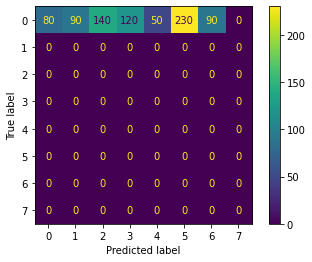

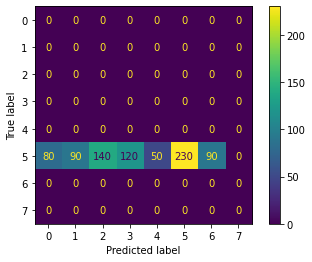

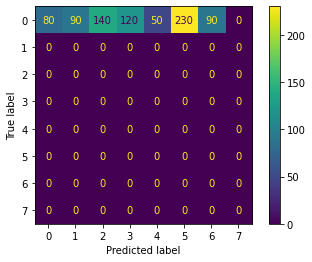

In [60]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list =train_raw(MyModel, train_dataset, batch_size=128, num_epochs=10, learning_rate=0.1, verbose=False)